In [35]:
import pandas as pd
import numpy as np

# Preparazione e Creazione dei dati
pc_on = np.random.randint(5, 51, size=345)
temperatura = np.random.uniform(18.0, 35.9, size=345)
giorni = np.arange(1, 346)
settimana = [1, 1, 1, 1, 1, 0, 0]
tipo_giorno = np.resize(settimana, 345)
consumo = 20 + (pc_on * 1.5) + (temperatura * 0.8) + (tipo_giorno * 10) + np.random.normal(0, 2, 345)

df = pd.DataFrame({
    'Giorno': giorni,
    'Temperatura': temperatura,
    'PC_Accesi': pc_on,
    'Tipo_Giorno': tipo_giorno,
    'Consumo_kWh': consumo,
})

df.to_csv('consumi_ufficio.csv', index=False)


In [36]:
'''Per non confondere il modello togliamo la tabella giorno'''
dataset = df.drop('Giorno', axis=1)

In [37]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

x = df.drop('Consumo_kWh', axis=1).values
y = df['Consumo_kWh'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(x_train_tensor, y_train_tensor.view(-1, 1))
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_ds = TensorDataset(x_val_tensor, y_val_tensor.view(-1, 1))
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [38]:
import torch.nn as nn 

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.linear = nn.Linear(4, 1)
    def forward(self, x):
        return self.linear(x)
    
reg_model = model()


In [39]:
# Primo output del modello senza training

x_input, y_input = val_ds[np.random.randint(0, 69, size=1)]
y_pred = reg_model(x_input)

consumo_predetto = y_pred.item()
consumo_reale = y_input.item()

print(f"Predizione: {consumo_predetto:,.0f} €")
print(f"Consumo Vero: {consumo_reale:,.0f} €")

Predizione: 67 €
Consumo Vero: 126 €


In [48]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(reg_model.parameters(), lr=0.001)

for epoch in range(3000):
    running_loss = 0.0
    for x_train, y_train in train_loader:
        optimizer.zero_grad()
        outputs = reg_model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    average_loss = running_loss/len(train_loader)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoca [{epoch+1}/3000], Loss: {average_loss:.4f}")


Epoca [100/3000], Loss: 4.1218
Epoca [200/3000], Loss: 4.2220
Epoca [300/3000], Loss: 4.2255
Epoca [400/3000], Loss: 4.1602
Epoca [500/3000], Loss: 4.1019
Epoca [600/3000], Loss: 4.1554
Epoca [700/3000], Loss: 4.1233
Epoca [800/3000], Loss: 4.2154
Epoca [900/3000], Loss: 4.0884
Epoca [1000/3000], Loss: 4.1108
Epoca [1100/3000], Loss: 4.1616
Epoca [1200/3000], Loss: 4.1222
Epoca [1300/3000], Loss: 4.1876
Epoca [1400/3000], Loss: 4.1633
Epoca [1500/3000], Loss: 4.1735
Epoca [1600/3000], Loss: 4.2726
Epoca [1700/3000], Loss: 4.0891
Epoca [1800/3000], Loss: 4.0676
Epoca [1900/3000], Loss: 4.1366
Epoca [2000/3000], Loss: 4.1517
Epoca [2100/3000], Loss: 4.2253
Epoca [2200/3000], Loss: 4.1501
Epoca [2300/3000], Loss: 4.1187
Epoca [2400/3000], Loss: 4.1365
Epoca [2500/3000], Loss: 4.1835
Epoca [2600/3000], Loss: 4.0734
Epoca [2700/3000], Loss: 4.1323
Epoca [2800/3000], Loss: 4.0910
Epoca [2900/3000], Loss: 4.2461
Epoca [3000/3000], Loss: 4.1162


In [49]:
reg_model.eval()
x_input, y_input = val_ds[np.random.randint(0, 69, size=1)]
with torch.no_grad():
    y_pred = reg_model(x_input)

consumo_predetto = y_pred.item()
consumo_reale = y_input.item()

print(f"Predizione: {consumo_predetto:,.0f} €")
print(f"Consumo Vero: {consumo_reale:,.0f} €")

Predizione: 95 €
Consumo Vero: 95 €


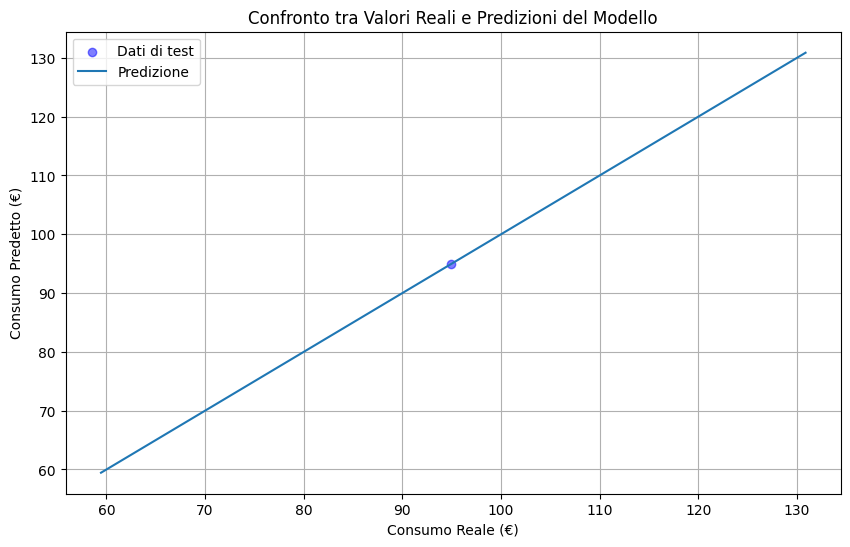

In [50]:
from matplotlib import pyplot as plt

y_reale = y_val_tensor.numpy().flatten()
y_predetto = y_pred.numpy().flatten()
plt.figure(figsize=(10, 6))
# Disegniamo i punti (Reale vs Predetto)
plt.scatter(consumo_reale, consumo_predetto, color='blue', alpha=0.5, label='Dati di test')

# Se il punto è su questa linea, la predizione è identica al valore reale
limiti = [y_reale.min(), y_reale.max()]
plt.plot(limiti, limiti, label='Predizione')

plt.xlabel('Consumo Reale (€)')
plt.ylabel('Consumo Predetto (€)')
plt.title('Confronto tra Valori Reali e Predizioni del Modello')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
path_modello = "consumo_ufficio.pth"

torch.save(reg_model.state_dict(), path_modello)

print(f"Modello salvato con successo in: {path_modello}")

Modello salvato con successo in: consumo_ufficio.pth
